In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/Deep Learning projekt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import numpy as np
from transformers import AutoTokenizer, RobertaModel, logging
import json
from torch.nn import TripletMarginLoss
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cosine

In [ ]:
logging.set_verbosity_error()
torch.manual_seed(69) # nice


class Data(Dataset):
  def __init__(self, n = None):
    ## n is a user specified length of dataset
    self.n = n

    ## data downloaded from https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/paraphrases
    data_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning projekt/quora_duplicates_triplets.jsonl"
    self.data = []
    with open(data_path, "r") as f:
      for line in f:
        triplet = json.loads(line)
        self.data.append(triplet)

  def __len__(self):
    return len(self.data) if self.n is None else self.n

  def __getitem__(self, idx):
    ## returns a tuple of (anchor, positive, negative)
    return self.data[idx]

data = Data()
train_set, test_set, val_set = random_split(data, [0.8, 0.15, 0.05])
batch_size = 32

## test_set skal bruges til at lave top k
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)

## test af dataset
print("Length: ", len(data))
print("Train: ", len(train_set))
print("Val: ", len(val_set))
print(train_set[1])

Length:  103663
Train:  82931
Val:  5183
['What are the expected consequences of Declaring 500 and 1000 rupee notes as illegal?', 'What is the use of banning 500 and 1000 rupee notes and introducing new 500 and 2000 rupee notes?', 'How will changing of Indian Currency affect the economy?']


In [ ]:
# Create a model class with variable output dimension(output_dim)
class sRoberta(torch.nn.Module):
    def __init__(self, output_dim):
        super(sRoberta, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        roberta_version ="roberta-base"
        self.roberta = RobertaModel.from_pretrained(roberta_version)
        self.tokenizer = AutoTokenizer.from_pretrained(roberta_version) # load pretrained transformer and tokenizer
        self.dense = torch.nn.Linear(768, output_dim)
        self.dropout = torch.nn.Dropout(p = 0.3)
        self.output_dim = output_dim
        self.criterion = TripletMarginLoss(margin=0.05)
        self.name = f"sRoberta_{output_dim}"
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids, attention_mask)
        out = out.last_hidden_state.mean(axis=1) ## take an average of the embedding of each word
        out = self.dropout(out)
        out = self.dense(out)

        return out

    def embeddings_from_sentences(self, sentences: list, grad = True):
      ## giv en liste med sætninger og få en tensor med embeddings
      if grad:
        self.train()
        token_and_mask = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(self.device)
        embedding = self(**token_and_mask)

      else:
        with torch.no_grad():
          self.eval()
          token_and_mask = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(self.device)
          embedding = self(**token_and_mask).cpu()

      return embedding

    def embeddings_from_batch(self, batch):
      ## giv et batch fra dataloaderen og få embeddings for anchor, pos og neg
      anchor, positive, negative = batch
      anchor_embed = self.embeddings_from_sentences(anchor)
      positive_embed = self.embeddings_from_sentences(positive)
      negative_embed = self.embeddings_from_sentences(negative)

      return anchor_embed, positive_embed, negative_embed

    def test(self, data_loader):
      self.eval()
      loss = 0
      with torch.no_grad():
        for batch in data_loader:
          anchor_embed, positive_embed, negative_embed = self.embeddings_from_batch(batch)
          loss += self.criterion(anchor_embed, positive_embed, negative_embed)

      loss /= len(data_loader)
      self.train()

      return loss.item()

    def train_model(self, epochs, train_loader, val_loader):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-5, weight_decay=1e-4)
      train_losses = torch.zeros(epochs)
      val_losses = torch.zeros(epochs)
      best_loss = float("inf")

      for epoch in range(epochs):
        for batch in tqdm(train_loader):
          optimizer.zero_grad()

          anchor_embed, positive_embed, negative_embed = self.embeddings_from_batch(batch)
          loss = self.criterion(anchor_embed, positive_embed, negative_embed)

          loss.backward()
          optimizer.step()

          torch.cuda.empty_cache()

        ## test på validation data
        val_loss = self.test(val_loader)

        train_losses[epoch] = loss.item()
        val_losses[epoch] = val_loss

        print(f"Epoch {epoch + 1}, train loss: {loss:.4f}, validation loss: {val_loss:.4f}\n")

        if val_loss < best_loss:
          best_loss = val_loss
          print(f"Best validation loss: {best_loss:.4f}")
          print("Saving best model...")
          self.save_model()

      path = f"data/{self.name}_train_losses.pt"
      torch.save(train_losses, path)
      torch.save(val_losses, path)
      print(f"\nFinished training. Saved train- and validation losses at {path}")

    def save_model(self):
      path = f"models/{self.name}.pt"
      torch.save(self.state_dict(), path)
      print("Model saved to {}\n".format(path))

    def load_model(self):
      path = f"models/{self.name}.pt"
      self.load_state_dict(torch.load(path))
      print("Model loaded from {}".format(path))

class sRobertaBase(sRoberta):
  def __init__(self):
    super(sRobertaBase, self).__init__(768) ## initialize random dense network since it wont be used
    self.dense = None
    self.name = f"sRoberta_1"

  def forward(self, input_ids, attention_mask):
    out = self.roberta(input_ids, attention_mask)
    out = out.last_hidden_state.mean(axis=1)

    return out

In [ ]:
def euclidean_distance(queries, docs):
  dist = torch.nn.PairwiseDistance(p=2)
  return dist(queries, docs)

def get_corpus_embeddings(model, corpus, batch_size = 64):
  model.eval()
  corpus_embeddings = torch.zeros(len(corpus), model.output_dim)
  print(f"Embedding corpus..  | batch size: {batch_size}")
  for i in tqdm(range(0, len(corpus), batch_size)):  ## batches up the corpus to preserve memory
    if len(corpus) - i < batch_size:  ## if corpus is smaller than batch size then change batch size (same as drop_last = False)
      batch_size = len(corpus) - i
    corpus_embeddings[i:i+batch_size] = model.embeddings_from_sentences(corpus[i:i+batch_size], grad=False) ## no need to calculate gradients

  return corpus_embeddings

def evaluate_model(corpus_embeddings, true_idxs, topk=2):
  pred_idxs = torch.zeros(len(corpus_embeddings), topk)

  print("Computing distances..")
  for i, query_embedding in enumerate(tqdm(corpus_embeddings)):
    distances = euclidean_distance(query_embedding, corpus_embeddings)
    distances[i] = float("inf")
    distances = - distances ## inverse distances since we want to find the closest
    _ , top_idxs = torch.topk(distances, k=topk)
    pred_idxs[i] = top_idxs

  return torch.isin(true_idxs, pred_idxs).float().mean().item(), pred_idxs.long()   ## also return pred_idxs to examine mismatches

In [ ]:
test_sentences = np.load("data/test_sentences.npy").tolist()
test_idxs = torch.from_numpy(np.load("data/test_idxs.npy"))

model = sRoberta(8)
model.load_model()
corpus_embeddings = get_corpus_embeddings(model, test_sentences)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model loaded from models/sRoberta_8.pt
Embedding corpus..  | batch size: 64


100%|██████████| 164/164 [00:21<00:00,  7.70it/s]


In [ ]:
acc, _ = evaluate_model(corpus_embeddings, test_idxs, topk=5)
print(acc)

Computing distances..


100%|██████████| 10490/10490 [00:05<00:00, 1815.86it/s]

0.9780743718147278


Model loaded from models/sRoberta_512.pt


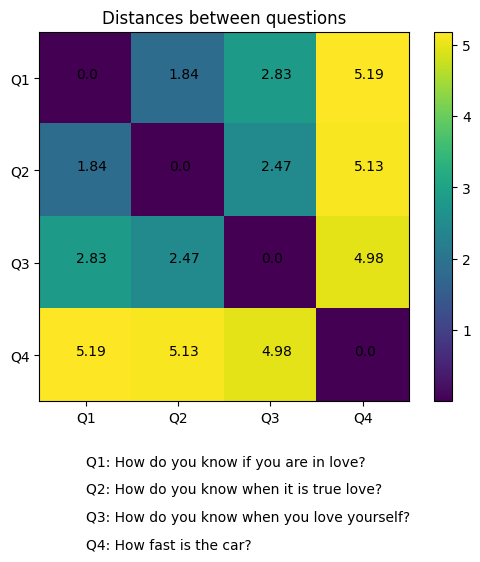

In [ ]:
model = sRoberta(512)
model.load_model()

sentences = ["How do you know if you are in love?",
             "How do you know when it is true love?",
             "How do you know when you love yourself?",
             "How fast is the car?"]

embeddings = model.embeddings_from_sentences(sentences, grad=False)

distances = torch.zeros(len(sentences), len(sentences))
for i in range(len(sentences)):
  for j in range(len(sentences)):
    dist = euclidean_distance(embeddings[i], embeddings[j])
    distances[i, j] = dist
    plt.text(i - 0.1, j, str(round(distances[i, j].item(), 2)))

for i, sentence in enumerate(sentences):
  plt.text(0, 4.2 + 0.3 * i, f"Q{i+1}: {sentence}")

plt.imshow(distances)
plt.xticks(range(len(sentences)), [f"Q{i+1}" for i in range(len(sentences))])
plt.yticks(range(len(sentences)), [f"Q{i+1}" for i in range(len(sentences))])
plt.title("Distances between questions")
plt.colorbar()
plt.savefig("figures/distances.png", dpi=300, bbox_inches="tight")
plt.show()

Model loaded from models/sRoberta_512.pt


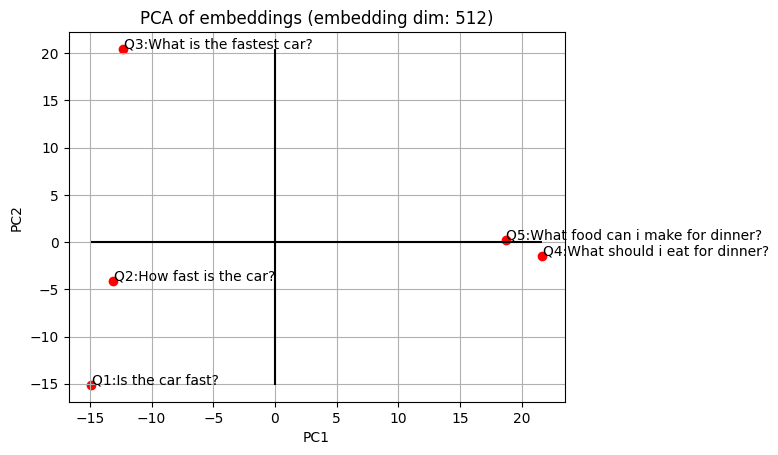

In [20]:
model = sRoberta(512)
model.load_model()
pca = PCA(n_components=2)
sentences = ["Is the car fast?", "How fast is the car?", "What is the fastest car?", "What should i eat for dinner?", "What food can i make for dinner?"]
embeddings = model.embeddings_from_sentences(sentences, grad=False).numpy()
scaled_embeddings = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

projected_embeddings = pca.fit_transform(scaled_embeddings)
plt.hlines(0, min(projected_embeddings[:, 0]), max(projected_embeddings[:, 0]), color="black")
plt.vlines(0, min(projected_embeddings[:, 1]), max(projected_embeddings[:, 1]), color="black")
plt.grid(True)

for i, p in enumerate(projected_embeddings):
  plt.scatter(p[0], p[1], color="red")
  plt.text(p[0] + 0.05, p[1] + 0.05, f"Q{i + 1}:" + sentences[i])

plt.title(f"PCA of embeddings (embedding dim: {embeddings.shape[1]})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("figures/pca.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
results = np.load("data/results.npy")
embed_sizes = [1, 8, 64, 128, 512, 768, 1024, 2048]

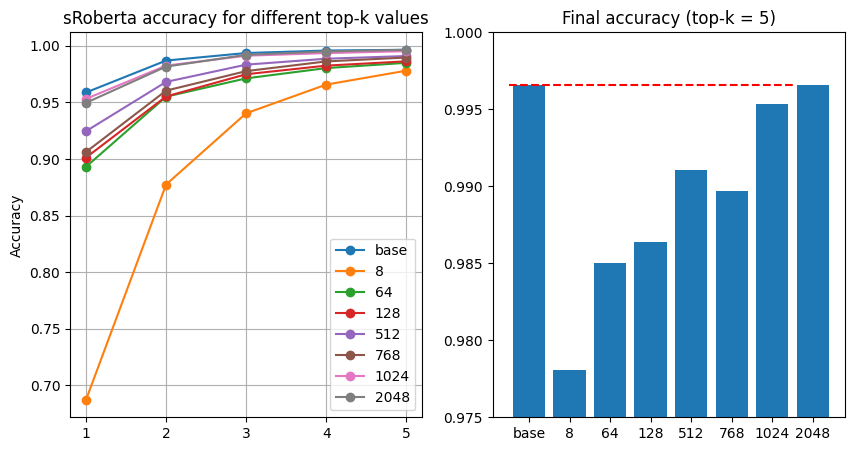

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

xlabels = [size if size != 1 else "base" for size in embed_sizes]

for i, embed_size in enumerate(embed_sizes):
  axs[0].plot(range(1, 6), results[i, :], "-o", label=xlabels[i])

axs[0].set_xticks(range(1, 6))
axs[0].set_ylabel("Accuracy")
axs[0].set_title("sRoberta accuracy for different top-k values")
axs[0].grid(True)
axs[0].legend()

axs[1].bar(range(len(embed_sizes)), results[:, -1])
axs[1].set_ylim(0.975, 1)
axs[1].set_xticks(range(len(embed_sizes)), xlabels)
axs[1].set_title("Final accuracy (top-k = 5)")
axs[1].hlines(max(results[:, -1]), -0.5, 6.5, linestyles = "dashed", color="red")

plt.savefig("figures/results.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
## testing computational times

import time

N = 100_000
n = 10000

embed_sizes = [1, 8, 64, 128, 512, 768, 1024, 2048]

time_results = np.zeros(len(embed_sizes))
dummy_queries = torch.randn(1, max(embed_sizes)).to("cuda")
dummy_docs = torch.randn(N, max(embed_sizes)).to("cuda")

for i, embed_size in enumerate(embed_sizes):
  if embed_size == 1:
    embed_size = 768
  start = time.time()
  for _ in range(n):
    euclidean_distance(dummy_queries[:, :embed_size], dummy_docs[:, :embed_size])
  end_distances = time.time() - start

  time_results[i] = end_distances
  print(f"Embedding size: {embed_size} | Time to compute {N * n} pairwise distances: {end_distances}")
  print()

np.save("data/time_results.npy", time_results)


Embedding size: 768 | Time to compute 1000000000 pairwise distances: 60.86193823814392

Embedding size: 8 | Time to compute 1000000000 pairwise distances: 3.3165857791900635

Embedding size: 64 | Time to compute 1000000000 pairwise distances: 5.783888578414917

Embedding size: 128 | Time to compute 1000000000 pairwise distances: 10.331140041351318

Embedding size: 512 | Time to compute 1000000000 pairwise distances: 40.88800835609436

Embedding size: 768 | Time to compute 1000000000 pairwise distances: 62.24049496650696

Embedding size: 1024 | Time to compute 1000000000 pairwise distances: 83.09961819648743

Embedding size: 2048 | Time to compute 1000000000 pairwise distances: 164.543128490448



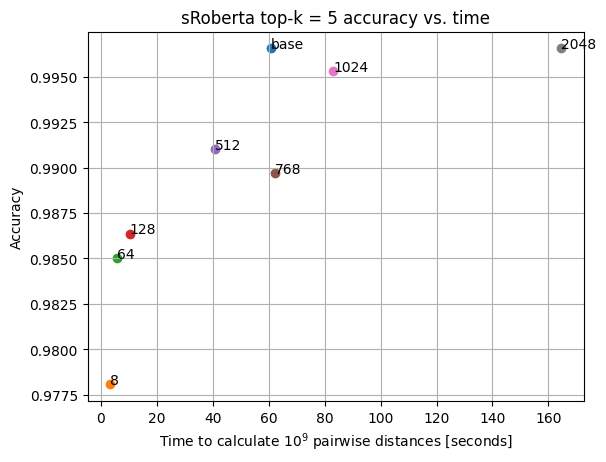

In [17]:
results = np.load("data/results.npy")
time_results = np.load("data/time_results.npy")

for i, embed_size in enumerate(embed_sizes):
  plt.scatter(time_results[i], results[i, -1])
  embed_size = "base" if embed_size == 1 else embed_size
  plt.annotate(embed_size, (time_results[i], results[i, -1]))

plt.grid(True)
plt.xlabel('Time to calculate $10^9$ pairwise distances [seconds]')
plt.ylabel('Accuracy')
plt.title("sRoberta top-k = 5 accuracy vs. time")
plt.savefig("figures/time_results.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
results[:, -1]

array([0.99656814, 0.97807437, 0.98503339, 0.98636794, 0.9910391 ,
       0.98970449, 0.9953289 , 0.99656814])